# Import the dependencies, construct the tool functions

In [5]:
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import random
import math as m
from sklearn.datasets import load_svmlight_file
TEST_SIZE=0.33

# 读入数据
def get_data_numpyArray(file_path):
    data = load_svmlight_file(file_path)
    return data[0].toarray(), data[1]

#将具有-1和1的标签数组转化为0和1的标签数组
def transform_ylable_from_posNe1_to_01(ylables):
    return np.array([int(y_item/2 + 0.5) for y_item in ylables])

#给数据集加一列1
def add_X_bColumn(X):
   b_train = np.ones(X.shape[0])
   return np.c_[X, b_train]

def sigmoid(inX):
    return 1.0/(1+np.exp(-inX))

def compute_lost(X,y,W):
    W = W.reshape(len(W),1)
    result = X.dot(W)
    lost = 0.0
    for i in range(X.shape[0]):
        if y[i] == 1:
            lost += -m.log(sigmoid(result[i,0]))
        else:
            lost += -m.log(1- sigmoid(result[i,0]))
    return lost/X.shape[0]   

def shuffle(X_train,y_train):
    for i in reversed(range(1, len(X_train))):
        j = random.randint(0,i)
        swap_x = X_train[i].copy()
        X_train[i] = X_train[j]
        X_train[j] = swap_x
        swap_y = y_train[i].copy()
        y_train[i] = y_train[j]
        y_train[j] = swap_y


# optimization function are constructed

In [6]:
def NAG(vs,dW,alpha, gamma=.9):
    vs = dW * alpha + vs * gamma
    return vs

def RMSProp(dW, G, alpha,gramma):
    eps_stable = 1e-7
    G = gramma * G + dW**2 *(1 -gramma)
    G_sq = (G + eps_stable)**0.5
    return  dW * alpha / G_sq    

def AdaDelta(dW, G, t,gramma):
    eps_stable = 1e-7
    G = gramma * G + dW**2 *(1 -gramma)
    G_sq = (G + eps_stable)**0.5
    t_sq = (t + eps_stable)**0.5
    delta_theta_t = dW * t_sq / G_sq 
    t = gramma * t + delta_theta_t**2 *(1 -gramma)  
    return delta_theta_t

def Adam(dW, G, m,belta,gramma,nga):
    eps_stable = 1e-7
    m = belta * m + dW *(1 -belta)
    G = gramma * G + dW**2 *(1 -gramma)
    alpha = nga * ((1- gramma)**0.5)/(1 - belta )
    G_sq = (G + eps_stable)**0.5
    return alpha * m / G_sq

# Construct the stochastic gradient descent function,adding optimization function

In [7]:
#返回值为每次迭代后W在训练集和测试集上损失   
def regression_stochastic_batch(X_train,y_train,X_test,y_test,W,numiter,eta,batch_size):
    iterations=[]
    lost_y_train = []
    shuffle(X_train,y_train)
    k = 0
    m = X_train.shape[0]
    for i in range(1,numiter+1):
        if(k + batch_size > m):
            shuffle(X_train,y_train)
            k = 0
        X_train_batch = X_train[k:k+batch_size]
        y_train_batch = y_train[k:k+batch_size]
        k = k + batch_size
        #计算梯度
        h = sigmoid(np.dot(X_train_batch, W))
        w_theta = np.dot(X_train_batch.transpose(), h - y_train_batch) * 2.0/X_train_batch.shape[0]
        #更新参数
        W -= eta * w_theta    
        lost_train = compute_lost(X_train,y_train,W)
        iterations.append(i)
        lost_y_train.append(lost_train)
    return iterations,lost_y_train

def regression_stochastic_batch_NAG(X_train,y_train,X_test,y_test,W,numiter,eta,batch_size):
    iterations=[]
    lost_y_train = []
    shuffle(X_train,y_train)
    k = 0
    m = X_train.shape[0]
    vs = np.zeros((X_train.shape[1],1))
    for i in range(1,numiter+1):
        if(k + batch_size > m):
            shuffle(X_train,y_train)
            k = 0
        X_train_batch = X_train[k:k+batch_size]
        y_train_batch = y_train[k:k+batch_size]
        k = k + batch_size
        #计算梯度
        h = sigmoid(np.dot(X_train_batch, W))
        w_theta = np.dot(X_train_batch.transpose(), h - y_train_batch) * 2.0/X_train_batch.shape[0]
        #更新参数
        W -= NAG(vs,w_theta,eta)    
        lost_train = compute_lost(X_train,y_train,W)
        iterations.append(i)
        lost_y_train.append(lost_train)
    return iterations,lost_y_train   
    
    

def regression_stochastic_batch_RMSProp(X_train,y_train,X_test,y_test,W,numiter,eta,gamma,batch_size):
    iterations=[]
    lost_y_train = []
    shuffle(X_train,y_train)
    k = 0
    m = X_train.shape[0]
    G = np.zeros((X_train.shape[1],1))
    for i in range(1,numiter+1):
        if(k + batch_size > m):
            shuffle(X_train,y_train)
            k = 0
        X_train_batch = X_train[k:k+batch_size]
        y_train_batch = y_train[k:k+batch_size]
        k = k + batch_size
        #计算梯度
        h = sigmoid(np.dot(X_train_batch, W))
        w_theta = np.dot(X_train_batch.transpose(), h - y_train_batch) * 2.0/X_train_batch.shape[0]
        #更新参数
        W -= RMSProp(w_theta,G,eta,gamma)
        lost_train = compute_lost(X_train,y_train,W)
        iterations.append(i)
        lost_y_train.append(lost_train)
    return iterations,lost_y_train   

def regression_stochastic_batch_AdaDelta(X_train,y_train,X_test,y_test,W,numiter,gamma,batch_size):
    iterations=[]
    lost_y_train = []
    shuffle(X_train,y_train)
    k = 0
    m = X_train.shape[0]
    G = np.zeros((X_train.shape[1],1))
    t = np.zeros((X_train.shape[1],1))
    for i in range(1,numiter+1):
        if(k + batch_size > m):
            shuffle(X_train,y_train)
            k = 0
        X_train_batch = X_train[k:k+batch_size]
        y_train_batch = y_train[k:k+batch_size]
        k = k + batch_size
        #计算梯度
        h = sigmoid(np.dot(X_train_batch, W))
        w_theta = np.dot(X_train_batch.transpose(), h - y_train_batch) * 2.0/X_train_batch.shape[0]
        #更新参数
        W -= AdaDelta(w_theta,G,t,gamma)
        lost_train = compute_lost(X_train,y_train,W)
        iterations.append(i)
        lost_y_train.append(lost_train)
    return iterations,lost_y_train      
        
def regression_stochastic_batch_Adam(X_train,y_train,X_test,y_test,W,numiter,beta,gamma,eta,batch_size):
    iterations=[]
    lost_y_train = []
    shuffle(X_train,y_train)
    k = 0
    m = X_train.shape[0]
    G = np.zeros((X_train.shape[1],1))
    mt = np.zeros((X_train.shape[1],1))
    for i in range(1,numiter+1):
        if(k + batch_size > m):
            shuffle(X_train,y_train)
            k = 0
        X_train_batch = X_train[k:k+batch_size]
        y_train_batch = y_train[k:k+batch_size]
        k = k + batch_size
        #计算梯度
        h = sigmoid(np.dot(X_train_batch, W))
        w_theta = np.dot(X_train_batch.transpose(), h - y_train_batch) * 2.0/X_train_batch.shape[0]
        #更新参数
        W -= Adam(w_theta,G,mt,beta,gamma,eta)
        lost_train = compute_lost(X_train,y_train,W)
        iterations.append(i)
        lost_y_train.append(lost_train)
    return iterations,lost_y_train            


# data pre-processing

In [8]:
#加载数据集
X, y = get_data_numpyArray("a9a.txt")
#把训练集添加一列全1，即添加参数b
X = add_X_bColumn(X)
#分割数据集
y = transform_ylable_from_posNe1_to_01(y)
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.33)
#将数据集的标签转化为列向量，方便使用矩阵乘法计算梯度
y_train = y_train.reshape(len(y_train),1)
y_test = y_test.reshape(len(y_test),1)
#全0初始化参数矩阵
W = np.zeros((X.shape[1],1))

# Comparison of the eta of stochastic gradient descent

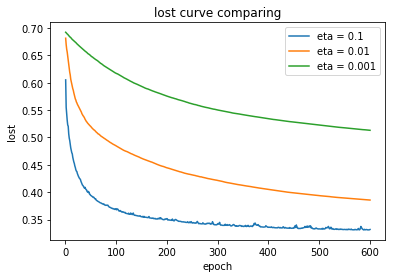

In [9]:
plt.figure(1)
plt.xlabel('epoch')
plt.ylabel('lost')
plt.title('lost curve comparing')
iterations,lost_y_train_normal_1= regression_stochastic_batch(X_train,y_train,X_test,y_test,W.copy(),600,0.1,64)
iterations,lost_y_train_normal_2= regression_stochastic_batch(X_train,y_train,X_test,y_test,W.copy(),600,0.01,64)
iterations,lost_y_train_normal_3= regression_stochastic_batch(X_train,y_train,X_test,y_test,W.copy(),600,0.001,64)
plt.plot(iterations, lost_y_train_normal_1,label='eta = 0.1')
plt.plot(iterations, lost_y_train_normal_2, label='eta = 0.01')
plt.plot(iterations, lost_y_train_normal_3,label='eta = 0.001')
plt.legend()
plt.show()

# Comparison of the eta of NAG

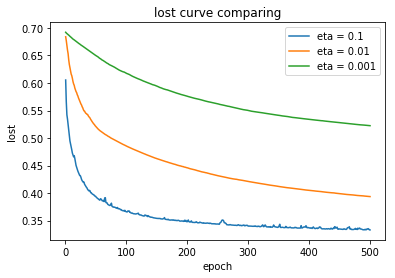

In [10]:
plt.figure(2)
plt.xlabel('epoch')
plt.ylabel('lost')
plt.title('lost curve comparing')
iterations,lost_y_train_NAG_1 = regression_stochastic_batch_NAG(X_train,y_train,X_test,y_test,W.copy(),500,0.1,64)
iterations,lost_y_train_NAG_2 = regression_stochastic_batch_NAG(X_train,y_train,X_test,y_test,W.copy(),500,0.01,64)
iterations,lost_y_train_NAG_3 = regression_stochastic_batch_NAG(X_train,y_train,X_test,y_test,W.copy(),500,0.001,64)
plt.plot(iterations, lost_y_train_NAG_1,label='eta = 0.1')
plt.plot(iterations, lost_y_train_NAG_2, label='eta = 0.01')
plt.plot(iterations, lost_y_train_NAG_3,label='eta = 0.001')
plt.legend()
plt.show()

# Comparison of the eta of RMSProp

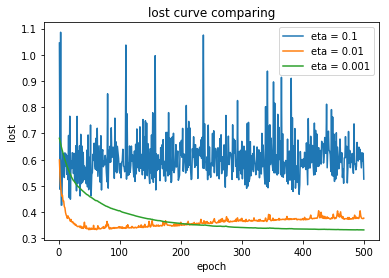

In [11]:
plt.figure(3)
plt.xlabel('epoch')
plt.ylabel('lost')
plt.title('lost curve comparing')
iterations,lost_y_train_1 = regression_stochastic_batch_RMSProp(X_train,y_train,X_test,y_test,W.copy(),500,0.1,0.9,64)
iterations,lost_y_train_2 = regression_stochastic_batch_RMSProp(X_train,y_train,X_test,y_test,W.copy(),500,0.01,0.9,64)
iterations,lost_y_train_3 = regression_stochastic_batch_RMSProp(X_train,y_train,X_test,y_test,W.copy(),500,0.001,0.9,64)
plt.plot(iterations, lost_y_train_1,label='eta = 0.1')
plt.plot(iterations, lost_y_train_2, label='eta = 0.01')
plt.plot(iterations, lost_y_train_3, label='eta = 0.001')
plt.legend()
plt.show()

# Comparison of the eta of Adam

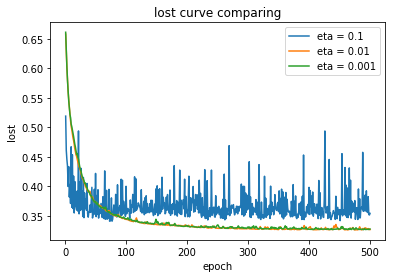

In [12]:
plt.figure(4)
plt.xlabel('epoch')
plt.ylabel('lost')
plt.title('lost curve comparing')
iterations,lost_y_train_1 = regression_stochastic_batch_Adam(X_train,y_train,X_test,y_test,W.copy(),500,0.9,0.999,0.1,64)
iterations,lost_y_train_2 = regression_stochastic_batch_Adam(X_train,y_train,X_test,y_test,W.copy(),500,0.9,0.999,0.01,64)
iterations,lost_y_train_3 = regression_stochastic_batch_Adam(X_train,y_train,X_test,y_test,W.copy(),500,0.9,0.999,0.01,64)
plt.plot(iterations, lost_y_train_1,label='eta = 0.1')
plt.plot(iterations, lost_y_train_2, label='eta = 0.01')
plt.plot(iterations, lost_y_train_3, label='eta = 0.001')
plt.legend()
plt.show()

# Comparison of the eta of all

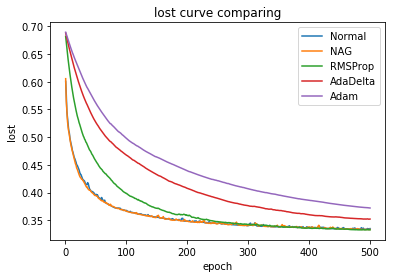

In [13]:
plt.figure(5)
plt.xlabel('epoch')
plt.ylabel('lost')
plt.title('lost curve comparing')
iterations,lost_y_train_normal= regression_stochastic_batch(X_train,y_train,X_test,y_test,W.copy(),500,0.1,64)
iterations,lost_y_train_NAG = regression_stochastic_batch_NAG(X_train,y_train,X_test,y_test,W.copy(),500,0.1,64)
iterations,lost_y_train_RMSProp = regression_stochastic_batch_RMSProp(X_train,y_train,X_test,y_test,W.copy(),500,0.001,0.9,64)
iterations,lost_y_train_AdaDelta = regression_stochastic_batch_AdaDelta(X_train,y_train,X_test,y_test,W.copy(),500,0.95,64)
iterations,lost_y_train_Adam = regression_stochastic_batch_Adam(X_train,y_train,X_test,y_test,W.copy(),500,0.9,0.999,0.001,64)
plt.plot(iterations, lost_y_train_normal,label='Normal')
plt.plot(iterations, lost_y_train_NAG, label='NAG')
plt.plot(iterations, lost_y_train_RMSProp,label='RMSProp')
plt.plot(iterations, lost_y_train_AdaDelta,label='AdaDelta')
plt.plot(iterations, lost_y_train_Adam,label='Adam')
plt.legend()
plt.show()